# Эксперименты с временным рядом стоимости арматуры с моделью LSTM

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 60)
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import timedelta, datetime
from copy import deepcopy

import torch
from darts import TimeSeries
from darts.metrics import mae, mape
from darts.models import BlockRNNModel
from darts.dataprocessing.transformers import Scaler
from sklearn.preprocessing import MinMaxScaler

import optuna
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from functools import partial
import random

In [3]:
torch.set_float32_matmul_precision('high')
use_cuda = torch.cuda.is_available()

if use_cuda:
    print('__CUDNN VERSION:', torch.backends.cudnn.version())
    print('__Number CUDA Devices:', torch.cuda.device_count())
    print('__CUDA Device Name:',torch.cuda.get_device_name(0))
    print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

__CUDNN VERSION: 8302
__Number CUDA Devices: 1
__CUDA Device Name: NVIDIA A2
__CUDA Device Total Memory [GB]: 15.630270464


In [4]:
FORECAST_LEN = 4 # Длина прогноза
OUT_OF_TIME_DIM = 20 # Размер отложенной выборки

In [5]:
def set_seed(seed: int = 42):
    """Set random seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
set_seed()

In [6]:
import logging
optuna.logging.set_verbosity(optuna.logging.WARNING)
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

# Данные

In [7]:
FORECAST_LEN = 4 # forecast horizon
OUT_OF_TIME_DIM = 20 # out-of-time dimension

In [8]:
df = pd.read_csv('prepared_dataset_al.csv', parse_dates=[0], dtype='float32')
print('Shape:', df.shape)

Shape: (333, 23)


In [9]:
# Извлекаем временной ряд с ценами на медь
data_ts = TimeSeries.from_dataframe(df, time_col='date', value_cols='lme_price_smooth')
# Извлекаем ковариаты
data_past_cov = TimeSeries.from_dataframe(df, time_col='date', value_cols=df.columns.values[1:-5])
# Возьмем срез данных для всего процесса развития модели ts & past_cov и out-of-time выборку
ts = data_ts[:-OUT_OF_TIME_DIM]
past_cov = data_past_cov[:-OUT_OF_TIME_DIM]
# out-of-time выборка будет использована лишь в самом конце

In [10]:
import datetime

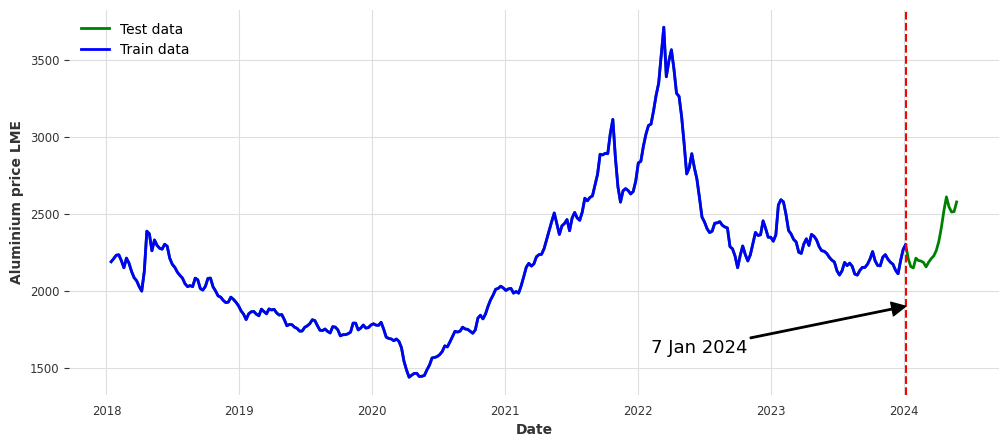

In [11]:
fig, ax = plt.subplots(figsize=(12, 5))
data_ts.plot(label="Test data", color='g')
ts.plot(label="Train data", color='b')
l1 = ax.axvline(x=ts.end_time(), color='r', linestyle='--', linewidth=1.5)
ax.annotate('7 Jan 2024', xy=(ts.end_time(), 1900), xytext=(ts.end_time() - datetime.timedelta(700), 1600),
            arrowprops=dict(facecolor='black', width=1, headwidth=10, headlength=10), fontsize = 13
            )
ax.set_ylabel('Aluminium price LME');
ax.set_xlabel('Date');
#plt.savefig('preview.png', dpi=400, format='png')

## Model initialization

LSTM

In [12]:
""" 
Function for building a LSTM Model.
"""

def build_lstm_model(
    in_len,
    out_len,
    hidden_dim,
    n_rnn_layers,
    lr,
    batch_size,
    epochs,
    dropout=0,
    hidden_fc_sizes=None,
    likelihood=None,
    callbacks=None
):
    # reproducibility
    torch.manual_seed(42)
    # some fixed parameters that will be the same for all models
    #MAX_N_EPOCHS = 200
    NR_EPOCHS_VAL_PERIOD = 2

    # throughout training we'll monitor the validation loss for early stopping
    early_stopper = EarlyStopping(monitor="val_loss", min_delta=0.0005, patience=5, verbose=False)
    if callbacks is None:
        callbacks = [early_stopper]
    else:
        callbacks = [early_stopper] + callbacks

    # detect if a GPU is available
    if torch.cuda.is_available():
        pl_trainer_kwargs = {
            "accelerator": "gpu",
            #"devices": [1],
            "callbacks": callbacks,
            'enable_progress_bar': True,
        }
        num_workers = 2
    else:
        pl_trainer_kwargs = {"callbacks": callbacks}
        num_workers = 0

    # build the LSTM model
    model = BlockRNNModel(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        model='LSTM',
        hidden_dim=hidden_dim,
        n_rnn_layers=n_rnn_layers,
        hidden_fc_sizes=hidden_fc_sizes,
        dropout=dropout,
        likelihood=likelihood,
        optimizer_kwargs={"lr": lr},
        batch_size=batch_size,
        n_epochs=epochs,
        nr_epochs_val_period=NR_EPOCHS_VAL_PERIOD,
        pl_trainer_kwargs=pl_trainer_kwargs,
        random_state=42
    )

    return model

## Cross-validation

In [13]:
def manual_backtest(model_settings,
                    ts,
                    past_covariates,
                    forecast_horizont=FORECAST_LEN, 
                    start_test=180,
                    step = 30,
                    save_curves=False,
                    rolling_window=False,
                    window_size=None,
                    verbose=True
                   ):
    '''
    Функция аналогична встроенной функции backtest
    '''
    shift = model_settings["in_len"]
    metrics = list() # Список для метрик
    prediction_curves = dict() # Список для последюущей визуализации кривых
    k=1
    # Скользящее или расширяющееся окно
    if rolling_window: 
        start_train = start_test - window_size
    else:
        start_train=0
    while True:
        if verbose is True:
            print('Iter #', k)
        cur_train = ts[start_train : start_test]
        cur_test = ts[start_test - shift : start_test + int(forecast_horizont)]
        # Инициализация scaler-ов
        scaler_ts, scaler_past_cov = Scaler(MinMaxScaler(feature_range=(0,1))), Scaler(MinMaxScaler(feature_range=(0,1)))
        # Есть ли экзогенные признаки
        if past_covariates is not None:
            past_cov_train = past_covariates[start_train : start_test]
            past_cov_test = past_covariates[start_test - shift : start_test + int(forecast_horizont)]
            
            cur_train_scaled, past_cov_train_scaled = scaler_ts.fit_transform(cur_train), scaler_past_cov.fit_transform(past_cov_train)
            cur_test_scaled, past_cov_test_scaled = scaler_ts.transform(cur_test), scaler_past_cov.transform(past_cov_test)
            
            model = build_lstm_model(
                **model_settings,
                out_len=forecast_horizont
            )
            model.fit(series=cur_train_scaled,
                      val_series=cur_test_scaled,
                      past_covariates=past_cov_train_scaled,
                      val_past_covariates=past_cov_test_scaled,
                      max_samples_per_ts=256,
                      num_loader_workers=2,
                      verbose=False)
            cur_pred_scaled = model.predict(series=cur_train_scaled,
                                            past_covariates=past_cov_train_scaled,
                                            n=int(forecast_horizont),
                                            verbose=False)
            cur_pred = scaler_ts.inverse_transform(cur_pred_scaled)
        # Если экзогенных признаков нет  
        else:
            cur_train_scaled = scaler_ts.fit_transform(cur_train)
            cur_test_scaled = scaler_ts.transform(cur_test)
            
            model = build_lstm_model(
                **model_settings,
                out_len=forecast_horizont
            )
            model.fit(series=cur_train_scaled,
                        val_series=cur_test_scaled,
                        max_samples_per_ts=256,
                        num_loader_workers=2, verbose=False)
            cur_pred_scaled = model.predict(series=cur_train_scaled,
                                            n=int(forecast_horizont),
                                            verbose=False)
            cur_pred = scaler_ts.inverse_transform(cur_pred_scaled)
        # Вычисляем метрику и добавляем в список   
        metric = mape(cur_test, cur_pred, intersect=True)
        metrics.append(metric)
        # n_epochs.append(model1.epochs_trained)
        # При необходимости можно собирать информацию о количестве эпох обучения
        # Добавляем спрогнозированную кривую в набор кривых для последующей отрисовки
        prediction_curves['pred_'+str(k)]=cur_pred
        k+=1
        
        start_test+=step
        if rolling_window==True:
            start_train+=step
        if start_test + int(forecast_horizont) > len(ts):
            break
            
    if save_curves==True:
        return metrics, prediction_curves
    else:
        return metrics

## Hyperparameter optimization (optuna)

In [14]:
class LoggingCallback:
    def __init__(self, interval=1):
        self.interval = interval

    def __call__(self, study, trial):
        if trial.number % self.interval == 0:
            print(f"Trial number: {trial.number}, Trial value: {trial.value:.2f}, Trial params: {trial.params}", end='\n\n')
            print(f"Best trial: {study.best_trial.number}, Best value: {study.best_value:.2f}, Best params: {study.best_trial.params}", end='\n\n')

In [15]:
def objective(trial, ts, past_cov, forecast_len = FORECAST_LEN):
    
    layers = []
    first_layer = trial.suggest_int("first_layer", 64, 512)
    second_layer = trial.suggest_int("second_layer", 16, first_layer)
    layers.append(first_layer)
    layers.append(second_layer)
    settings = {
        "in_len": trial.suggest_int("in_len", 4, 52),
        "hidden_dim" : trial.suggest_int("hidden_dim", 20, 512),
        "n_rnn_layers" : trial.suggest_int("n_rnn_layers", 1, 5),
        "hidden_fc_sizes" : layers,
        "lr" : trial.suggest_float("lr", 5e-6, 1e-3, log=True),
        "batch_size" : trial.suggest_categorical("batch_size", [16, 24, 32]),
        "epochs" : trial.suggest_int("epochs", 50, 250, step=10)
    }
    if settings["n_rnn_layers"]>1:
        settings["dropout"] = trial.suggest_float("dropout", 0.0, 0.4)
    
#     settings_for_backtest = {
#         "rolling_window" : trial.suggest_categorical("rolling_window", [False])
#     }
    settings_for_backtest = {
        "rolling_window" : trial.suggest_categorical("rolling_window", [True, False])
    }
    if settings_for_backtest["rolling_window"] == True:
        settings_for_backtest["window_size"] = trial.suggest_categorical("window_size", [104, 156])

    # Evaluate how good it is on the cross_validation for ts
    metrics = manual_backtest(settings,
                              ts=ts,
                              past_covariates=past_cov,
                              **settings_for_backtest)
    mean_metric = np.mean(metrics)
    return mean_metric if mean_metric != np.nan else float("inf")

def opt(ts, past_cov, iterations):
    opt_function=partial(objective, ts=ts, past_cov=past_cov)
    study = optuna.create_study(direction="minimize")
    print("A new study created!", end='\n\n')
    # параметр timeout работает подозрительно, лучше работать с n_trials
    study.optimize(opt_function, n_trials=iterations, callbacks=[LoggingCallback()])
    #study.optimize(opt_function, n_trials=iterations)
    print(f"Number of finished trials: {len(study.trials)}", end='\n\n')
    print(f"Best trial: {study.best_trial.number}, Best value: {study.best_value:.2f}, Best params: {study.best_trial.params}", end='\n\n')
#     for key, value in study.best_trial.params.items():
#         print("  {}: {}".format(key, value))
    return study

## Build, fit and evaluate

In [16]:
def setup_params(best_params):
    if best_params['rolling_window']==True:
        settings_for_backtest = {
            'rolling_window':True,
            'window_size': best_params['window_size']
        }
        del best_params['rolling_window']
        del best_params['window_size']
    else:
        settings_for_backtest = {
            'rolling_window':False
        }
        del best_params['rolling_window']
    best_params["hidden_fc_sizes"] = [best_params["first_layer"], best_params["second_layer"]]
    del best_params["first_layer"]
    del best_params["second_layer"]
    return best_params, settings_for_backtest

In [41]:
def fit_model(model_settings,
              backtest_settings,
              ts,
              past_cov=None,
              forecast_len=FORECAST_LEN):
    input_size = model_settings["in_len"]
    
    if past_cov is not None:
        scaler_ts = Scaler(MinMaxScaler(feature_range=(0,1)))
        scaler_past_cov = Scaler(MinMaxScaler(feature_range=(0,1)))
        
        if backtest_settings["rolling_window"]==True:
            window_size = backtest_settings["window_size"]
            ts_train = ts[-(window_size+forecast_len) : -forecast_len]
            ts_valid = ts[-(input_size+forecast_len) : ]
            past_cov_train = past_cov[-(window_size+forecast_len) : -forecast_len]
            past_cov_valid = past_cov[-(input_size+forecast_len) : ]
        else:
            ts_train = ts[ : -forecast_len]
            ts_valid = ts[-(input_size+forecast_len) : ]
            past_cov_train = past_cov[ : -forecast_len]
            past_cov_valid = past_cov[-(input_size+forecast_len) : ]
        
        ts_train_scaled = scaler_ts.fit_transform(ts_train)
        ts_valid_scaled = scaler_ts.transform(ts_valid)
        past_cov_train_scaled = scaler_past_cov.fit_transform(past_cov_train)
        past_cov_valid_scaled = scaler_past_cov.transform(past_cov_valid)
        
        model = build_lstm_model(**model_settings,
                                 out_len=forecast_len
                                )
        model.fit(series=ts_train_scaled,
                  val_series=ts_valid_scaled,
                  past_covariates=past_cov_train_scaled,
                  val_past_covariates=past_cov_valid_scaled,
                  max_samples_per_ts=256,
                  num_loader_workers=2)
        
        return model, scaler_ts, scaler_past_cov
    
    else:
        scaler_ts = Scaler(MinMaxScaler(feature_range=(0,1)))
        
        if backtest_settings["rolling_window"]==True:
            window_size = backtest_settings["window_size"]
            ts_train = ts[-(window_size+forecast_len) : -forecast_len]
            ts_valid = ts[-(input_size+forecast_len) : ]
        else:
            ts_train = ts[ : -forecast_len]
            ts_valid = ts[-(input_size+forecast_len) : ]
        ts_train_scaled = scaler_ts.fit_transform(ts_train)
        ts_valid_scaled = scaler_ts.transform(ts_valid)
        
        model = build_lstm_model(**model_settings,
                                 out_len=forecast_len
                                )
        model.fit(series=ts_train_scaled,
                  val_series=ts_valid_scaled,
                  max_samples_per_ts=256,
                  num_loader_workers=2)
        
        return model, scaler_ts

In [51]:
def evaluation(model_settings,
               backtest_settings,
               data_ts,
               data_past_cov,
               forecast_len=FORECAST_LEN,
               out_of_time_dim=OUT_OF_TIME_DIM,
               refit = None
              ):
    '''
    Функция для построения прогноза и вычисления метрик на out-of-time выборке
    data_ts - датасет временного ряда
    data_past_cov - датасет ковариант
    model_settings и backtest_settings - настройки модели,
    forecast_len - длина прогноза,
    out_of_time_dim - размер выборки out-of-time
    '''
    start_point = 0
    metrics = list()
    prediction_curves = {}
    step = 1
    input_size = model_settings["in_len"]
    out_of_time_ts = data_ts[-(out_of_time_dim + input_size):]
    out_of_time_past_cov = data_past_cov[-(out_of_time_dim + input_size):]
    price = data_ts.copy()
    if refit == True:
        while True:
            train_ts = data_ts[:-out_of_time_dim+start_point]
            train_past_cov = data_past_cov[:-out_of_time_dim+start_point]
            model, scaler_ts, scaler_past_cov = fit_model(model_settings=model_settings,
                                         backtest_settings=backtest_settings,
                                         ts=train_ts,
                                         past_cov=train_past_cov
                                        )
            test_ts = out_of_time_ts[start_point : start_point + input_size]
            test_ts_scaled = scaler_ts.transform(test_ts)
            test_past_cov = out_of_time_past_cov[start_point : start_point + input_size]
            test_past_cov_scaled = scaler_past_cov.transform(test_past_cov)
            
            prediction_scaled = model.predict(n=int(forecast_len),
                                              series=test_ts_scaled,
                                              past_covariates=test_past_cov_scaled
                                             )
            prediction = scaler_ts.inverse_transform(prediction_scaled)
            
            metric = mape(prediction, price, intersect=True)
            metrics.append(metric)
            
            start_point+=step
            prediction_curves[start_point]=prediction
            if start_point + input_size + int(forecast_len) > len(out_of_time_ts):
                break
        print("MAPE: {:.2f} +- {:.2f}".format(np.mean(metrics), np.std(metrics)))
        return prediction_curves, metrics, model, scaler_ts, scaler_past_cov
    
    elif refit == False:
        train_ts = data_ts[:-out_of_time_dim]
        train_past_cov = data_past_cov[:-out_of_time_dim]
        print("Building model")
        model, scaler_ts, scaler_past_cov = fit_model(model_settings=model_settings,
                                     backtest_settings=backtest_settings,
                                     ts=train_ts,
                                     past_cov=train_past_cov
                                    )
        while True:
            test_ts = out_of_time_ts[start_point : start_point + input_size]
            test_ts_scaled = scaler_ts.transform(test_ts)
            test_past_cov = out_of_time_past_cov[start_point : start_point + input_size]
            test_past_cov_scaled = scaler_past_cov.transform(test_past_cov)
            
            prediction_scaled = model.predict(int(forecast_len),
                                              series=test_ts_scaled,
                                              past_covariates=test_past_cov_scaled
                                             )
            prediction = scaler_ts.inverse_transform(prediction_scaled)
            
            metric = mape(prediction, price, intersect=True)
            metrics.append(metric)
            start_point+=step
            prediction_curves[start_point]=prediction
            if start_point + input_size + int(forecast_len) > len(out_of_time_ts):
                break
        print("MAPE: {:.2f} +- {:.2f}".format(np.mean(metrics), np.std(metrics)))
        return prediction_curves, metrics, model, scaler_ts, scaler_past_cov
    
    else:
        print("Установите значение параметра refit!")
        pass

# Building model with covariates

### Hyperparameter optimization

In [17]:
study = opt(ts=ts, past_cov=past_cov, iterations=30)

A new study created!

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Trial number: 0, Trial value: 7.11, Trial params: {'first_layer': 113, 'second_layer': 81, 'in_len': 27, 'hidden_dim': 100, 'n_rnn_layers': 5, 'lr': 7.2575902310461705e-06, 'batch_size': 16, 'epochs': 100, 'dropout': 0.047387772122294086, 'rolling_window': False}

Best trial: 0, Best value: 7.11, Best params: {'first_layer': 113, 'second_layer': 81, 'in_len': 27, 'hidden_dim': 100, 'n_rnn_layers': 5, 'lr': 7.2575902310461705e-06, 'batch_size': 16, 'epochs': 100, 'dropout': 0.047387772122294086, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Trial number: 1, Trial value: 10.96, Trial params: {'first_layer': 193, 'second_layer': 107, 'in_len': 45, 'hidden_dim': 77, 'n_rnn_layers': 2, 'lr': 4.3469841357508945e-05, 'batch_size': 24, 'epochs': 160, 'dropout': 0.32187947455292926, 'rolling_window': True, 'window_size': 104}

Best trial: 0, Best value: 7.11, Best params: {'first_layer': 113, 'second_lay

Exception ignored in: <function _releaseLock at 0x7faeb008ae60>
Traceback (most recent call last):
  File "/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/logging/__init__.py", line 228, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
[W 2024-06-16 04:11:34,684] Trial 9 failed with parameters: {'first_layer': 207, 'second_layer': 17, 'in_len': 7, 'hidden_dim': 140, 'n_rnn_layers': 2, 'lr': 5.6592354510366954e-05, 'batch_size': 24, 'epochs': 250, 'dropout': 0.2887838698796375, 'rolling_window': True, 'window_size': 156} because of the following error: RuntimeError('DataLoader worker (pid(s) 61704) exited unexpectedly').
Traceback (most recent call last):
  File "/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1120, in _try_get_data
    data = self._data_queue.get(timeout=timeout)
  File "/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/queue.py", line 179, in get
    raise Empty
_queue.Empty

The above exception 

RuntimeError: DataLoader worker (pid(s) 61704) exited unexpectedly

In [23]:
best_params = study.best_trial.params
model_settings, backtest_settings = setup_params(best_params)

In [24]:
model_settings

{'in_len': 8,
 'hidden_dim': 60,
 'n_rnn_layers': 1,
 'lr': 6.882120554523833e-06,
 'batch_size': 32,
 'epochs': 170,
 'hidden_fc_sizes': [113, 56]}

In [25]:
backtest_settings

{'rolling_window': True, 'window_size': 104}

### Backtest with refit on each step

In [27]:
bt_metrics, pred_ts = manual_backtest(model_settings=model_settings,
                                      ts=ts,
                                      past_covariates=past_cov,
                                      save_curves=True,
                                      **backtest_settings)

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5


In [28]:
print("Backtest MAPE: {:.2f} +- {:.2f}".format(np.mean(bt_metrics), np.std(bt_metrics)))

Backtest MAPE: 5.83 +- 2.41


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


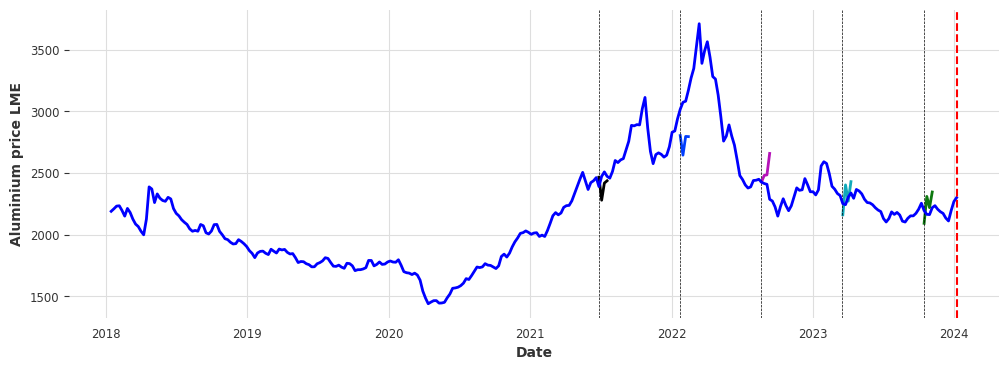

In [30]:
fig, ax = plt.subplots(figsize=(12, 4))
for key, value in pred_ts.items():
    value.plot(label=None);
    ax.axvline(x=value.start_time() - datetime.timedelta(1), color='black', linestyle='--', linewidth=0.5)
ts.plot(color='blue', label=None)
l1 = ax.axvline(x=ts.end_time(), color='r', linestyle='--', linewidth=1.5)
ax.set_ylabel('Aluminium price LME');
ax.set_xlabel('Date');
plt.savefig('Backtest_lstm.png', dpi=400, format='png')

### Fit and evaluate without refitting

In [52]:
prediction_curves_without_refit, \
metrics_without_refit, \
model_non_refited, \
scaler_ts_without_refit, \
scaler_past_cov_without_refit = evaluation(model_settings=model_settings,
                                           backtest_settings=backtest_settings,
                                           data_ts=data_ts,
                                           data_past_cov=data_past_cov,
                                           forecast_len=FORECAST_LEN,
                                           out_of_time_dim=OUT_OF_TIME_DIM,
                                           refit = False)

Building model


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

MAPE: 6.22 +- 3.90


<Axes: xlabel='date'>

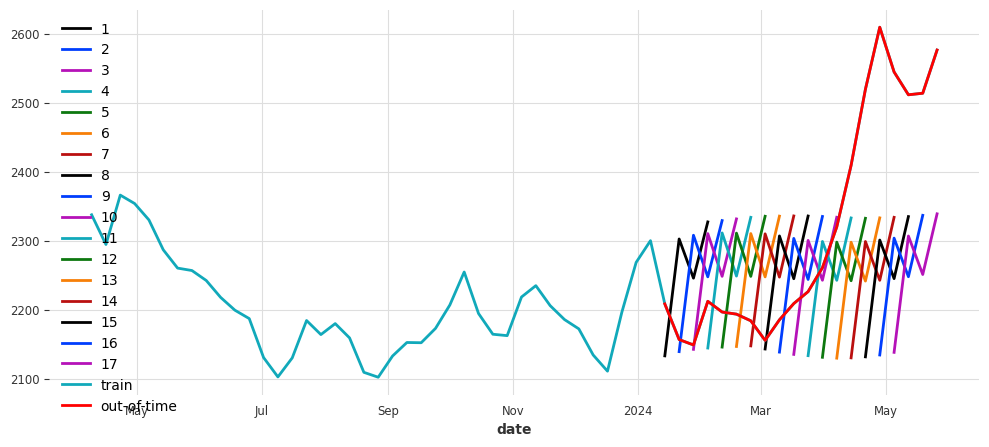

In [53]:
plt.figure(figsize=(12,5))
for key, value in prediction_curves_without_refit.items():
    value.plot(label=key)
data_ts[-3*OUT_OF_TIME_DIM:].plot(label='train')
data_ts[-OUT_OF_TIME_DIM:].plot(label='out-of-time', color='r')

### Fit and evaluate with refitting

In [55]:
prediction_curves_with_refit, \
metrics_with_refit, \
model_refited, \
scaler_ts_with_refit, \
scaler_past_cov_with_refit = evaluation(model_settings=model_settings,
                                           backtest_settings=backtest_settings,
                                           data_ts=data_ts,
                                           data_past_cov=data_past_cov,
                                           forecast_len=FORECAST_LEN,
                                           out_of_time_dim=OUT_OF_TIME_DIM,
                                           refit = True)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

MAPE: 6.22 +- 3.79


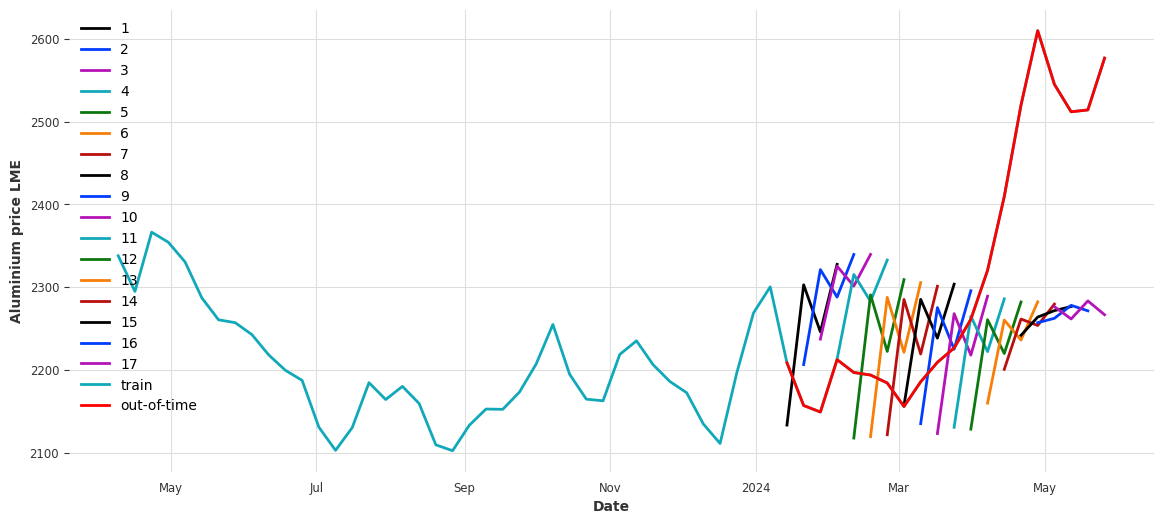

In [56]:
fig, ax = plt.subplots(figsize=(14, 6))
for key, value in prediction_curves_with_refit.items():
    value.plot(label=key)
data_ts[-3*OUT_OF_TIME_DIM:].plot(label='train')
data_ts[-OUT_OF_TIME_DIM:].plot(label='out-of-time', color='r')
ax.set_ylabel('Aluminium price LME');
ax.set_xlabel('Date');
plt.savefig('Out_of_time_test_lstm.png', dpi=400, format='png')